In [27]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [28]:
!pip install tensorflow_text==2.8.2
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import tensorflow_text
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow_hub as hub

In [30]:
df = pd.read_csv('/content/Cleaned Comments MKBHD.csv', encoding='utf8')
df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag,Lemmatized,Length,Positive count,Negative count,Sentiment
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"['world', 'phones', 'normal', 'refreshing', 's...","[('world', 'n'), ('phones', 'n'), ('normal', '...","['world', 'phone', 'normal', 'refresh', 'see',...",19,3,1,0.11
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"['feel', 'next', 'logical', 'step', 'smart', '...","[('feel', 'v'), ('next', 'a'), ('logical', 'a'...","['feel', 'next', 'logical', 'step', 'smart', '...",14,3,0,0.21
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"['still', 'pixel', 'surprise', 'hear', 'colour...","[('still', 'r'), ('pixel', 'a'), ('surprise', ...","['still', 'pixel', 'surprise', 'hear', 'colour...",24,2,1,0.04
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"['like', 'said', 'think', 'smart', 'forging', ...","[('like', None), ('said', 'v'), ('think', 'v')...","['like', 'say', 'think', 'smart', 'forge', 'pa...",29,8,1,0.24
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"['high', 'refresh', 'rate', 'mid', 'rangers', ...","[('high', 'a'), ('refresh', 'n'), ('rate', 'n'...","['high', 'refresh', 'rate', 'mid', 'ranger', '...",15,4,0,0.27


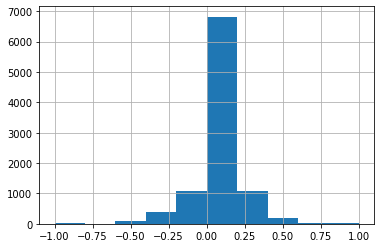

In [31]:
df['Sentiment'].hist()

In [32]:
len(df['Sentiment'])

9744

In [33]:
def label_sentiments(score):
    if score > 0:
      return 1
    elif score == 0:
      return 0
    elif score < 0:
      return -1

In [34]:
df['Label'] = df['Sentiment'].apply(label_sentiments)
df['Label']

0       1
1       1
2       1
3       1
4       1
       ..
9739    1
9740    1
9741    0
9742    0
9743    1
Name: Label, Length: 9744, dtype: int64

In [35]:
df['Label'].value_counts()

 1    4931
 0    3217
-1    1596
Name: Label, dtype: int64

In [36]:
df_negative = df[df['Label'] == -1]
df_neutral = df[df['Label'] == 0]
df_positive = df[df['Label'] == 1]

print(f'Shape of Negative Entries: {df_negative.shape}')
print(f'Shape of Positive Entries: {df_positive.shape}')
print(f'Shape of Neutral Entries: {df_neutral.shape}')

Shape of Negative Entries: (1596, 16)
Shape of Positive Entries: (4931, 16)
Shape of Neutral Entries: (3217, 16)


In [37]:
df_downsampled = pd.concat([df_negative, df_neutral.sample(df_negative.shape[0]), df_positive.sample(df_negative.shape[0])])
df_downsampled.shape

(4788, 16)

In [38]:
df_downsampled['Label'].value_counts()

-1    1596
 0    1596
 1    1596
Name: Label, dtype: int64

### Split data into train-test split

In [39]:
from sklearn.model_selection import train_test_split
np.random.seed(10)

# X = df_downsampled['Title']
# y = df_downsampled['Label']
X = df['Title']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(f'Train Shape: {X_train.shape}')
print(f'Test Shape: {X_test.shape}')
print(f'Train Labels Shape: {y_train.shape}')
print(f'Test Labels SHape: {y_test.shape}')

Train Shape: (7308,)
Test Shape: (2436,)
Train Labels Shape: (7308,)
Test Labels SHape: (2436,)


In [40]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [41]:
def get_embedding(sentence):
  preprocessed = bert_preprocess(sentence)
  return bert_encoder(preprocessed)['pooled_output']

In [42]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')
preprocessed = bert_preprocess(text_input)
encoded = bert_encoder(preprocessed)

dropout = tf.keras.layers.Dropout(0.1, name='dropout')(encoded['pooled_output'])
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout)

model = tf.keras.Model(inputs=[text_input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
229/229 [==============================] - 98s 362ms/step - loss: 0.6483 - accuracy: 0.3506
Epoch 2/20
229/229 [==============================] - 81s 355ms/step - loss: 0.6286 - accuracy: 0.3794
Epoch 3/20
229/229 [==============================] - 81s 353ms/step - loss: 0.6178 - accuracy: 0.3905
Epoch 4/20
229/229 [==============================] - 81s 352ms/step - loss: 0.6086 - accuracy: 0.4000
Epoch 5/20
229/229 [==============================] - 81s 353ms/step - loss: 0.6139 - accuracy: 0.4048
Epoch 6/20
229/229 [==============================] - 81s 353ms/step - loss: 0.6117 - accuracy: 0.4112
Epoch 7/20
229/229 [==============================] - 81s 356ms/step - loss: 0.6073 - accuracy: 0.4216
Epoch 8/20
229/229 [==============================] - 82s 359ms/step - loss: 0.6115 - accuracy: 0.4231
Epoch 9/20
229/229 [==============================] - 81s 354ms/step - loss: 0.6068 - accuracy: 0.4317
Epoch 10/20
229/229 [==============================] - 81s 352ms/step - l